Compare the E(B-V) map from LAMBDA vs. MAF.

LAMBDA map is from https://lambda.gsfc.nasa.gov/product/foreground/fg_sfd_get.cfm (specifically, the lambda_sfd_ebv.fits file). Since the LAMBDA map is HEALPix map with nside= 512, MAF dustmap is accessed with the HEALPix slicer with the same resolution.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import healpy as hp
import pandas as pd

In [2]:
datadir= '/home/docmaf/lsstData'
nside= 512

Access the MAF extinction map

In [3]:
import lsst.sims.maf.db as db
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.maps as maps

In [4]:
dbpath = '%s/minion_1016_sqlite_new_dithers.db'%datadir
opsdb = db.OpsimDatabase(dbpath)
simdata = opsdb.fetchMetricData(['fieldRA', 'fieldDec'], sqlconstraint=None)

Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_maf/2.8.0.sims/python/lsst/sims/maf/maps/dustMap.py:25: UserWarning: Slicer value of nside (512) different from map value (128), using slicer value
  % (slicePoints['nside'],self.nside ))


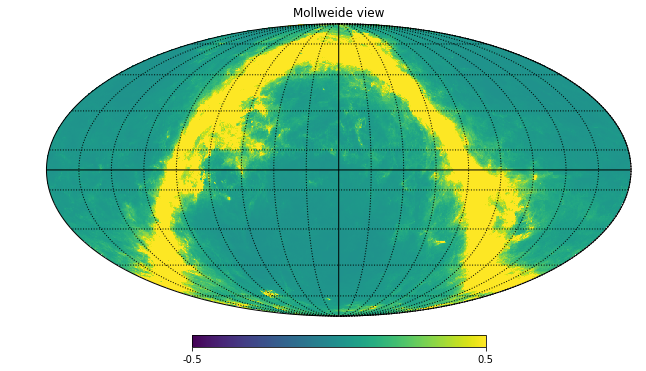

In [5]:
dustmap = maps.DustMap()
slicer = slicers.HealpixSlicer(latLonDeg=False, nside=nside)
slicer.setupSlicer(simdata)
result = dustmap.run(slicer.slicePoints)

# plot the ebv map to check whats up
hp.mollview(result['ebv'], flip='astro', rot=(0,0,0), min=-0.5, max=.5)
hp.graticule(dpar=20, dmer=20, verbose=False)

Read in the LAMBDA Map
- Since the map has nested ordering, need to convert to ring as have pixel numbers corresponding to the latter.
- Since the map uses Galactic coordinates, need to convert to equatorial.
    - We want to apply the coordinate transformation to the map. Apparently version 1.12 of healpy has a method to do it, but that version only appears available for linux, so I'm just copying/pasting source code for the method here.

In [6]:
# read in the map
filename = '%s/lambda_sfd_ebv.fits'%datadir
ebv_map_orig = hp.read_map(filename, nest=True)

# convert to ring since thats the ordering we have in MAF
ebv_map_ring = hp.pixelfunc.reorder(map_in=ebv_map_orig, n2r=True)

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/fitsfunc.py:343: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


In [7]:
# method from here: https://github.com/healpy/healpy/blob/master/healpy/rotator.py
from healpy import pixelfunc
def rotate_map(self, m):
        """Rotate a HEALPix map to a new reference frame
        This function first rotates the pixels centers of the new reference
        frame to the original reference frame, then uses hp.get_interp_val
        to interpolate bilinearly the pixel values, finally fixes Q and U
        polarization by the modification to the psi angle caused by
        the Rotator using Rotator.angle_ref.
        Parameters
        ----------
        m : np.ndarray
            Input map, 1 map is considered I, 2 maps:[Q,U], 3 maps:[I,Q,U]
        Returns
        -------
        m_rotated : np.ndarray
            Map in the new reference frame
        """
        if pixelfunc.maptype(m) == 0:  # a single map is converted to a list
            m = [m]
        npix = len(m[0])
        nside = pixelfunc.npix2nside(npix)
        theta_pix_center, phi_pix_center = pixelfunc.pix2ang(
            nside=nside, ipix=np.arange(npix)
        )

        # Rotate the pixels center of the new reference frame to the original frame
        theta_pix_center_rot, phi_pix_center_rot = self.I(
            theta_pix_center, phi_pix_center
        )

        # Interpolate the original map to the pixels centers in the new ref frame
        m_rotated = [
            pixelfunc.get_interp_val(each, theta_pix_center_rot, phi_pix_center_rot)
            for each in m
        ]

        # Rotate polarization
        if len(m_rotated) > 1:
            # Create a complex map from QU  and apply the rotation in psi due to the rotation
            # Slice from the end of the array so that it works both for QU and IQU
            L_map = (m_rotated[-2] + m_rotated[-1] * 1j) * np.exp(
                1j * 2 * self.angle_ref(theta_pix_center, phi_pix_center)
            )

            # Overwrite the Q and U maps with the correct values
            m_rotated[-2] = np.real(L_map)
            m_rotated[-1] = np.imag(L_map)
        else:
            m_rotated = m_rotated[0]

        return m_rotated

In [8]:
# rotate the map
r = hp.rotator.Rotator(coord=['G','C']) # rotator object: G= galactic --> C= equatorial
ebv_map_rot = rotate_map(r, ebv_map_ring)  # rotate the map

Compare the maps

In [9]:
ebv_map = {}
ebv_map['MAF'] = result['ebv']
ebv_map['LAMBDA'] = ebv_map_rot

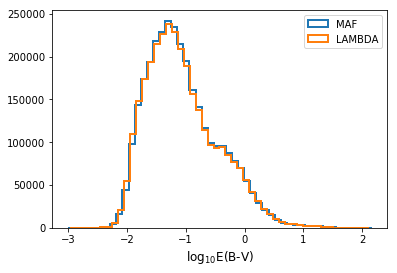

In [10]:
# pslot histogram of both map
for key in ebv_map:
    plt.hist(np.log10(ebv_map[key]), label=key, histtype='step', lw=2, bins=50)
plt.legend()
plt.xlabel(r'log$_{10}$E(B-V)', fontsize=12)
plt.show()

Things looks pretty similar but they are not exactly the same.

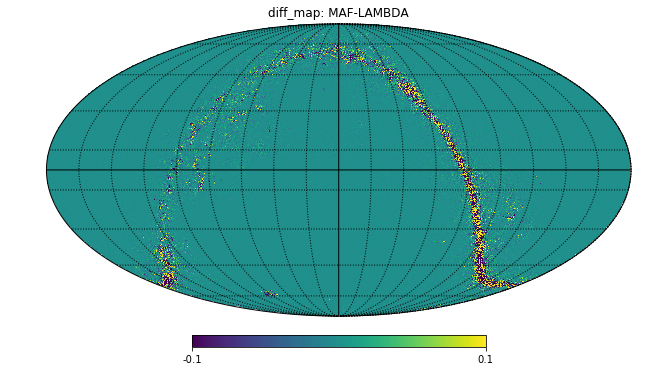

In [11]:
# check the difference
diff_map = ebv_map['MAF']-ebv_map['LAMBDA']
# plot it to check
hp.mollview(diff_map, flip='astro', rot=(0,0,0), min=-.1,max= .1, title='diff_map: MAF-LAMBDA')
hp.graticule(dpar=20, dmer=20, verbose=False)

The difference is primarily along the the galactic plane.

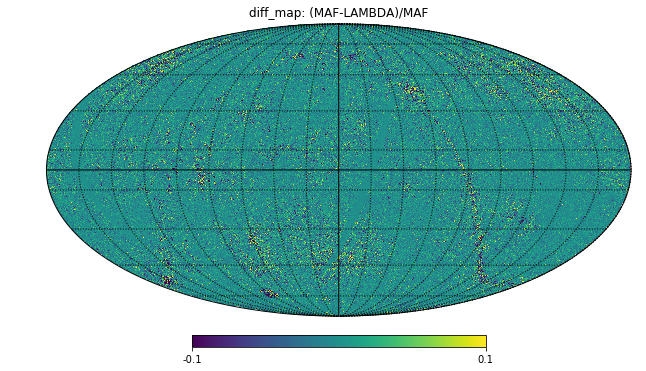

In [12]:
# check fractional difference
diff_map = (ebv_map['MAF']-ebv_map['LAMBDA'])/ebv_map['MAF']
# plot it to check
hp.mollview(diff_map, flip='astro', rot=(0,0,0), min=-.1,max= .1, title='diff_map: (MAF-LAMBDA)/MAF')
hp.graticule(dpar=20, dmer=20, verbose=False)

The artifacts arent that strong but there are features along the galactic plane + some patches in the sky.

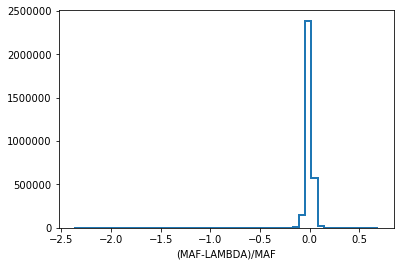

In [13]:
# plot the histogram of the fractional difference
plt.hist(diff_map, histtype= 'step', lw= 2,bins=50)
plt.xlabel('(MAF-LAMBDA)/MAF')

#### Re-create the histograms as in https://github.com/humnaawan/MAF-Related-Notebooks/blob/master/DESC-ScienceReq_1%2C10yrOptimization-renormalized1yr.ipynb
Not printing out the stuff etc. Just implementing the cuts and getting the relevant pixel numbers.

In [14]:
# read in depth data
dir_paths= {}
dir_paths['1yr']= '%s/Depth_Data_1yr/'%datadir
dir_paths['10yr']= '%s/Depth_Data_10yr/'%datadir

filenames= {}
filenames['1yr'] = [f for f in os.listdir(dir_paths['1yr']) if any([f.endswith('.npz') and not f.startswith('._')])]
filenames['10yr'] = [f for f in os.listdir(dir_paths['10yr']) if any([f.endswith('.npz') and not f.startswith('._') and not f.__contains__('_masked_')])]

In [15]:
from collections import OrderedDict
# set up without maf .. for consistency, I guess.
orderBand= ['i', 'u', 'g', 'r', 'z', 'y']
data= OrderedDict()
for case in filenames.keys():
    for ith in range(len(filenames[case])): #[::-1]:
        filename= [f for f in filenames[case][::-1] if f.__contains__('_%s_'%orderBand[ith])][0]
        os.chdir(dir_paths[case])
        key= filename.split('_Rep')[0].split('unmasked_')[1]
        data[case + '_' + key]= np.load(filename)

In [16]:
depth_nside= 256

In [17]:
import numpy.ma as ma
dataMaps= OrderedDict()
for key in data.keys():
    dataMaps[key]= data[key]['metricValues'].view(ma.MaskedArray)
    dataMaps[key].mask= data[key]['mask']
    dataMaps[key].fill_value= data[key]['fill']

In [18]:
# need to change the coadd depth since minion1016 doesnt treat the 1yr WFD right.
wanted1yr_medianDepth= {'g': 25.377165833786055,
 'i': 24.910057884620223,
 'r': 25.565945074516804,
 'u': 23.795160853950424,
 'y': 23.315667199085482,
 'z': 24.002597276614527}

for key in dataMaps.keys():
    if key.__contains__('1yr'):
        band= key.split('1yr_')[1]
        #print(band)
        inSurveyIndex= np.where(dataMaps[key].mask == False)[0]
        medDepth= np.median(dataMaps[key].data[inSurveyIndex])
        #print('Median depth as read: ', np.median(dataMaps[key].data[inSurveyIndex]))
        delm= wanted1yr_medianDepth[band]-medDepth
        #print('m_wanted-m_current = ', delm)
        dataMaps[key].data[:]+=delm
        #print('Renormalized map. \nNew median: ', np.median(dataMaps[key].data[inSurveyIndex]))
        #print('')

In [19]:
allBandData_Ind={}  # dictionary for pixels that are common in all six bands with depth>0.
for key in dataMaps.keys():
    inSurveyIndex= np.where(dataMaps[key].mask == False)[0]
    positiveDepth= np.where(dataMaps[key].data>=0.)[0]
    positiveInSurvey= list(set(inSurveyIndex).intersection(positiveDepth))
    
    yrTag= key.split('yr')[0]+'yr'
        
    if yrTag not in allBandData_Ind.keys():
        allBandData_Ind[yrTag]= positiveInSurvey  
    else:
        allBandData_Ind[yrTag]= list(set(allBandData_Ind[yrTag]).intersection(positiveInSurvey))

In [20]:
iCutPixels= {}   # store the good pixel indices for plotting later.
lowCuts= {'1yr': [24.0], '10yr': [25.0],}

for yrTag in lowCuts:
    iCutPixels[yrTag]= {}
    # run over different cuts
    for lowCut in lowCuts[yrTag]:
        bandKeys= [yrTag+'_'+x for x in orderBand] # want to maintain i ugrzy order.
        iBandKey= [b for b in bandKeys if b.__contains__('i')][0]  # select out the i-band key
        
        # find the pixels satisfying the iBand cut.
        iBandCutInd= np.where((dataMaps[iBandKey].data[allBandData_Ind[yrTag]]>=lowCut))[0]
        iCutPixels[yrTag][lowCut]= np.array(allBandData_Ind[yrTag])[iBandCutInd] # store

In [21]:
def plot_ebv_hists(ebv_maps, yrTag, lowCut, band, nBins= 20, noBandDependency= False, bins= None):
    # function to plot a log10(extinction) before and after the magnitude cut
    print('%s: i>%s'%(yrTag, lowCut))
    
    if bins is not None: nBins= bins  # in case user inputs bin edges
        
    plt.clf()
    for key in ebv_maps.keys():
        if noBandDependency:
            # work with allBand>0 footprint
            _, bins, _= plt.hist(np.log10(ebv_maps[key][allBandData_Ind[yrTag]]), label= '%s: allBand>0'%key,
                                 bins= nBins,
                                 histtype='step', lw= 2)#, color='b')

        else:
            # work with pixels without any cuts: band dependent
            inSurveyIndex= np.where(dataMaps['%s_%s'%(yrTag, band)].mask == False)[0]
            _, bins, _= plt.hist(np.log10(ebv_maps[key][inSurveyIndex]), label= '%s: no cuts'%key,  bins= nBins,
                                 histtype='step', lw= 2)#, color='b',)
        # work with pixels after cuts
        plt.hist(np.log10(ebv_maps[key][iCutPixels[yrTag][lowCut]]), label= '%s: i > %s; allBand>0'%(key, lowCut),
                 bins= bins,
                 histtype='step', lw= 2)#, color='r')
    
    plt.gcf().set_size_inches(6, 4)
    if noBandDependency:
        plt.title('%s'%(yrTag), fontsize= 12)
    else:
        plt.title('%s: %s band'%(yrTag, band), fontsize= 12)
    plt.legend(fontsize= 12, bbox_to_anchor= (1,1))# loc= "upper right")
    plt.xlabel(r'log$_{10}$E(B-V)', fontsize= 12)
    #if xlim is not None: plt.xlim(xlim[0], xlim[1])
    #plt.gca().set_xscale('log')
    plt.show()

In [22]:
# need to downgrade
for key in ebv_map:
    ebv_map[key]= hp.ud_grade(map_in= ebv_map[key], nside_out= 256)

1yr: i>24.0


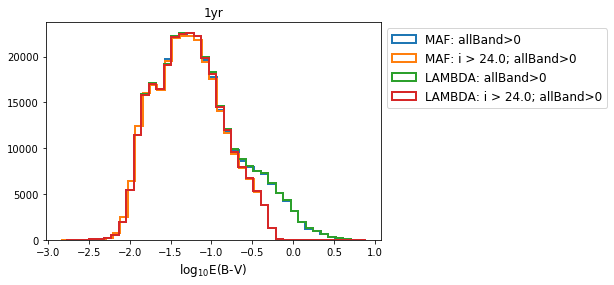

10yr: i>25.0


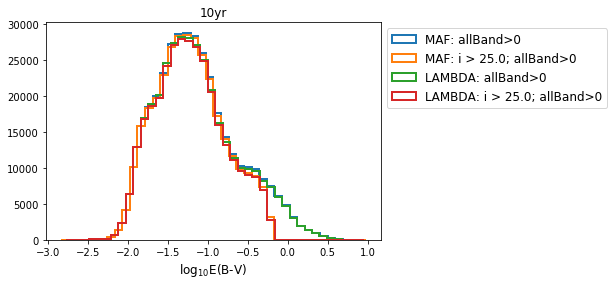

In [23]:
plot_ebv_hists(ebv_map, '1yr', 24.0, '', nBins= 40, noBandDependency= True, )#xlim= [-0.5,5.5])
plot_ebv_hists(ebv_map, '10yr', 25.0, '', nBins= 40, noBandDependency= True, )#xlim= [-0.5,5.5])

Ok things look comparable.

1yr: i>24.0


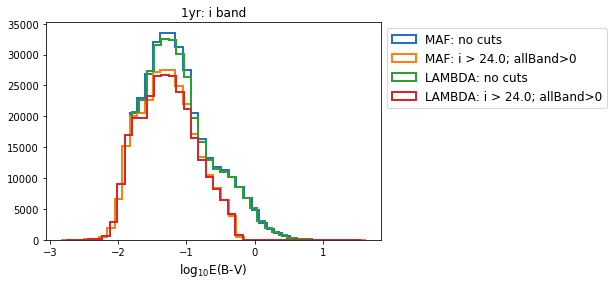

10yr: i>25.0


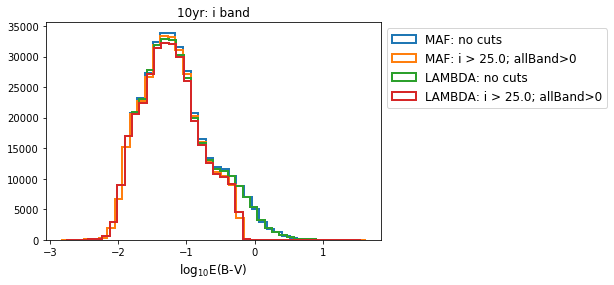

1yr: i>24.0


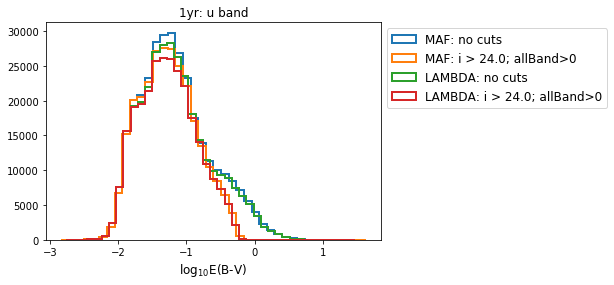

10yr: i>25.0


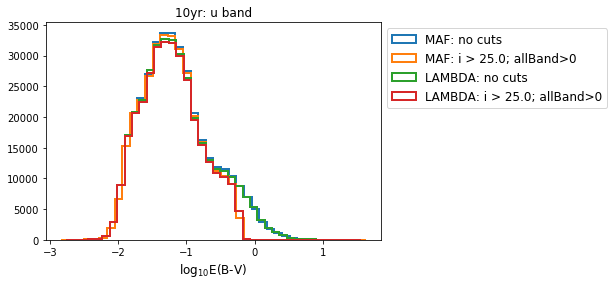

1yr: i>24.0


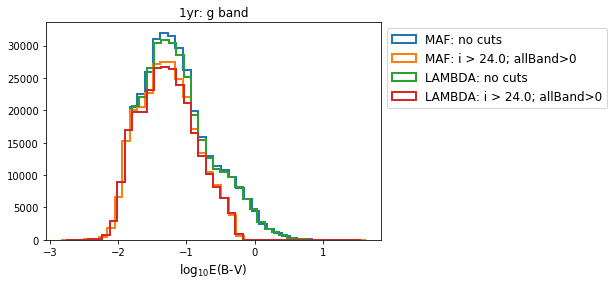

10yr: i>25.0


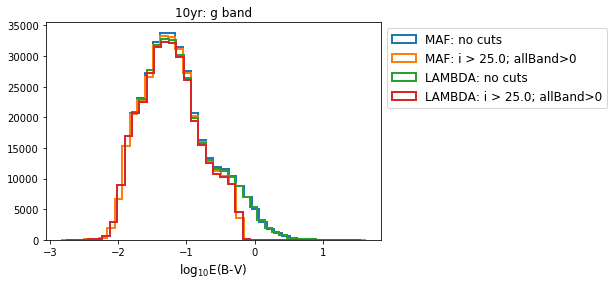

1yr: i>24.0


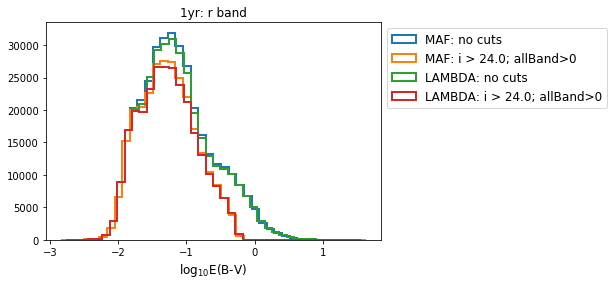

10yr: i>25.0


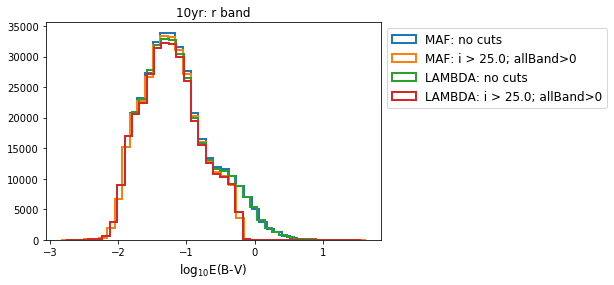

1yr: i>24.0


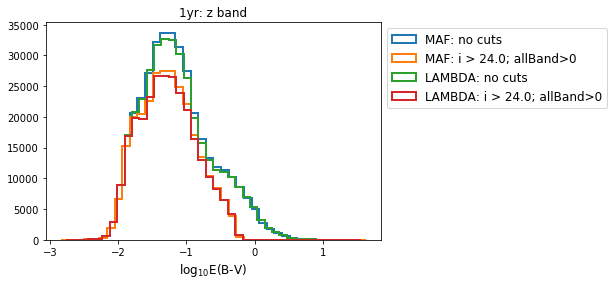

10yr: i>25.0


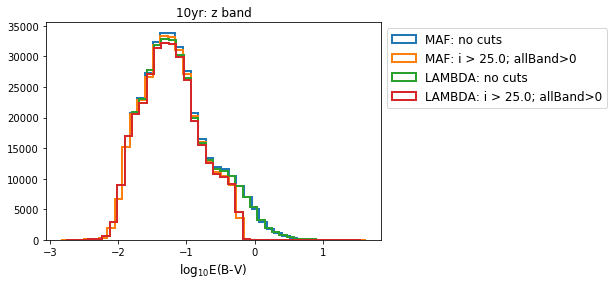

1yr: i>24.0


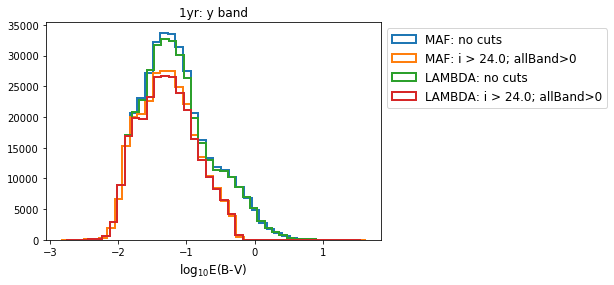

10yr: i>25.0


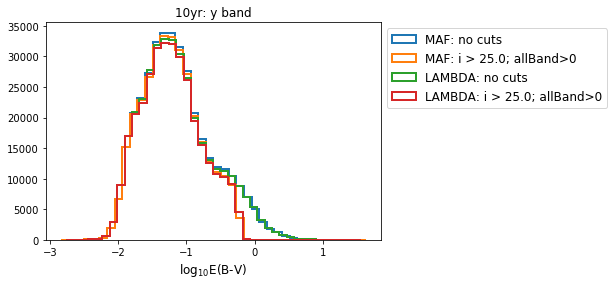

In [24]:
for band in orderBand:
    plot_ebv_hists(ebv_map, '1yr', 24.0, band, nBins= 40)
    plot_ebv_hists(ebv_map, '10yr', 25.0, band, nBins= 40)

Hm things are more different than the allBand histograms above. Basic trends before/after cuts are the same though.